In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pylab
import math
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from pyod.models.knn import KNN
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

#Библиотеки для stacking
from vecstack import stacking
#from pystacknet.pystacknet import StackNetRegressor #проблема с установкой
from mlxtend.regressor import StackingCVRegressor
from mlens.ensemble import SuperLearner
from sklearn.ensemble import StackingRegressor

%matplotlib inline

In [4]:
df=pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Квартиры Киров/Квартиры_Киров_выбока_2.xlsx', sheet_name = 0)
df.head()

,Комнатность,LN(Общая площадь),Общая площадь,Площадь кухни,Жилая площадь,Этаж 1,Этаж 2,Этажей в доме,Ремонт,Материал стен,...,последний,средний,деревянный,кирпичный,монолитный,панельный,дизайнерский,евро,косметический,требует ремонта
0,2к,3.799974,44.7,5.900000,29.458690,5,последний,5,евро,панельный,...,1,0,0,0,0,1,0,1,0,0
1,1к,3.465736,32.0,6.900000,17.655975,2,средний,5,косметический,кирпичный,...,0,1,0,1,0,0,0,0,1,0
2,студия,3.502550,33.2,6.633333,18.193506,3,последний,3,евро,кирпичный,...,1,0,0,1,0,0,0,1,0,0
3,2к,3.943522,51.6,8.800000,28.744021,6,средний,7,евро,кирпичный,...,0,1,0,1,0,0,0,1,0,0
4,3к,3.998201,54.5,18.000000,27.597229,18,средний,19,дизайнерский,панельный,...,0,1,0,0,0,1,1,0,0,0


1. Выборка 1 - без исключения выбросов (с учетом нормализации и стандартизации).
2. Выборка 2 - исключение экстремальных выбросов.
3. Выборка 3 - исключение выбросов по общей площади и цене.
4. Выборка 4 - исключение выбросов по логарифмированным общей площади и цене.
5. Выборка 5 - исключение выбросов алгоритмом KNN.

<font size = 3><div style="text-align: justify">**Выборка 1:**</div></font>

<font size = 2><div style="text-align: justify">**Библиотека vecstack:**</div></font>

In [67]:
df_v1 = df.copy()
len(df_v1)

2399

In [68]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [16]:
models = [CatBoostRegressor(iterations=2500, 
                            random_seed=5, 
                            learning_rate=0.008, 
                            max_depth=4,
                            verbose=0),
          make_pipeline(StandardScaler(), MLPRegressor(hidden_layer_sizes = (256, 64, 32), 
                                                       activation = 'relu', 
                                                       solver = 'adam', 
                                                       alpha = 2, 
                                                       max_iter = 2000)),
          XGBRegressor(),
          LGBMRegressor(),
          DecisionTreeRegressor()]
        
S_train, S_test = stacking(models, 
                           X_train, 
                           Y_train, 
                           X_test, 
                           regression = True, 
                           metric = mae, 
                           n_folds = 3,
                           shuffle = True, 
                           random_state = 0, 
                           verbose = 2)

#можно попробовать NN
reg = LinearRegression()
reg = reg.fit(S_train, Y_train)

#preds = clf.predict(S_test)
#plt_sct(y_test,preds)

pred_train = reg.predict(S_train)
mse_train = mse(Y_train, pred_train)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = reg.predict(S_test)
mse_test = mse(Y_test, pred_test)

print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [CatBoostRegressor]
    fold  0:  [0.11701921]
    fold  1:  [0.11492167]
    fold  2:  [0.12157931]
    ----
    MEAN:     [0.11784007] + [0.00277926]
    FULL:     [0.11783812]

model  1:     [Pipeline]
    fold  0:  [0.13918557]
    fold  1:  [0.14790886]
    fold  2:  [0.15198252]
    ----
    MEAN:     [0.14635898] + [0.00533804]
    FULL:     [0.14635605]

model  2:     [XGBRegressor]
    fold  0:  [0.12732632]
    fold  1:  [0.12399213]
    fold  2:  [0.12503437]
    ----
    MEAN:     [0.12545094] + [0.00139269]
    FULL:     [0.12545116]

model  3:     [LGBMRegressor]
    fold  0:  [0.12594965]
    fold  1:  [0.12081883]
    fold  2:  [0.12769464]
    ----
    MEAN:     [0.12482104] + [0.00291828]
    FULL:     [0.12481954]

model  4:     [DecisionTreeRegressor]
    fold  0:  [0.18029623]
    fold  1:  [0.17942819]
    fold  2:  [0.18949584]
    ----
   

C:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


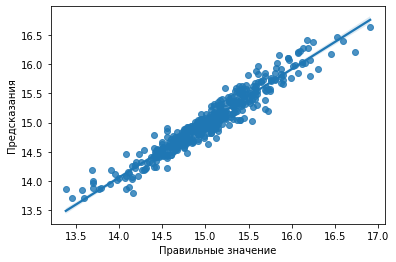

In [17]:
sns.regplot(Y_test, pred_test)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.show()

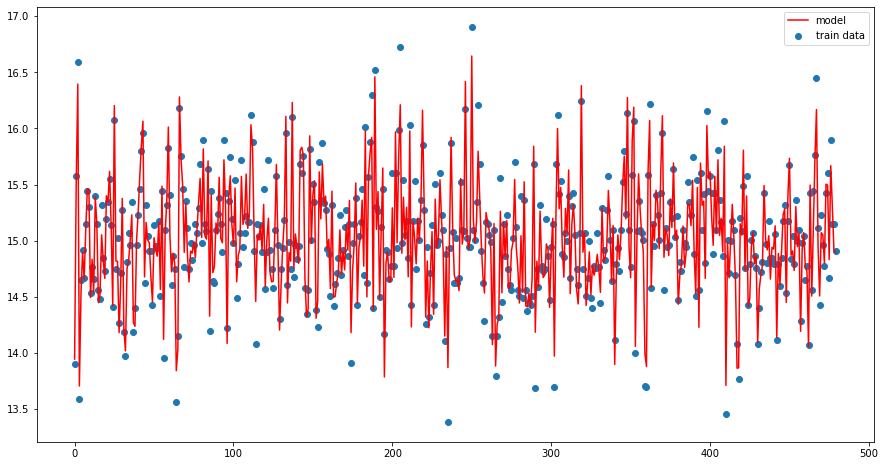

In [18]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(Y_test)), pred_test, c='r', label='model');
plt.scatter(range(len(Y_test)), Y_test, label='train data')
plt.legend();

In [42]:
models = [CatBoostRegressor(iterations=2500, 
                            random_seed=5, 
                            learning_rate=0.008, 
                            max_depth=4,
                            verbose=0),
          AdaBoostRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor()]
        
S_train, S_test = stacking(models, 
                           X_train, 
                           Y_train, 
                           X_test, 
                           regression = True, 
                           metric = mae, 
                           n_folds = 3,
                           shuffle = True, 
                           random_state = 0, 
                           verbose = 2)

reg = LinearRegression()
reg = reg.fit(S_train, Y_train)

pred_train = reg.predict(S_train)
mse_train = mse(Y_train, pred_train)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = reg.predict(S_test)
mse_test = mse(Y_test, pred_test)

print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [CatBoostRegressor]
    fold  0:  [0.11701921]
    fold  1:  [0.11492167]
    fold  2:  [0.12157931]
    ----
    MEAN:     [0.11784007] + [0.00277926]
    FULL:     [0.11783812]

model  1:     [AdaBoostRegressor]
    fold  0:  [0.18007369]
    fold  1:  [0.17151287]
    fold  2:  [0.19175892]
    ----
    MEAN:     [0.18111516] + [0.00829816]
    FULL:     [0.18110961]

model  2:     [XGBRegressor]
    fold  0:  [0.12732632]
    fold  1:  [0.12399213]
    fold  2:  [0.12503437]
    ----
    MEAN:     [0.12545094] + [0.00139269]
    FULL:     [0.12545116]

model  3:     [LGBMRegressor]
    fold  0:  [0.12594965]
    fold  1:  [0.12081883]
    fold  2:  [0.12769464]
    ----
    MEAN:     [0.12482104] + [0.00291828]
    FULL:     [0.12481954]

model  4:     [GradientBoostingRegressor]
    fold  0:  [0.12021163]
    fold  1:  [0.12529159]
    fold  2:  [0.12922997]

In [69]:
models = [CatBoostRegressor(iterations=2500, 
                            random_seed=5, 
                            learning_rate=0.008, 
                            max_depth=4,
                            verbose=0),
          AdaBoostRegressor(),
          XGBRegressor(),
          LGBMRegressor(),
          GradientBoostingRegressor(),
          RandomForestRegressor()]
        
S_train, S_test = stacking(models, 
                           X_train, 
                           Y_train, 
                           X_test, 
                           regression = True, 
                           metric = mae, 
                           n_folds = 3,
                           shuffle = True, 
                           random_state = 0, 
                           verbose = 2)

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [CatBoostRegressor]
    fold  0:  [0.11701921]
    fold  1:  [0.11492167]
    fold  2:  [0.12157931]
    ----
    MEAN:     [0.11784007] + [0.00277926]
    FULL:     [0.11783812]

model  1:     [AdaBoostRegressor]
    fold  0:  [0.18572501]
    fold  1:  [0.17150835]
    fold  2:  [0.19125820]
    ----
    MEAN:     [0.18283052] + [0.00831856]
    FULL:     [0.18282613]

model  2:     [XGBRegressor]
    fold  0:  [0.12732632]
    fold  1:  [0.12399213]
    fold  2:  [0.12503437]
    ----
    MEAN:     [0.12545094] + [0.00139269]
    FULL:     [0.12545116]

model  3:     [LGBMRegressor]
    fold  0:  [0.12594965]
    fold  1:  [0.12081883]
    fold  2:  [0.12769464]
    ----
    MEAN:     [0.12482104] + [0.00291828]
    FULL:     [0.12481954]

model  4:     [GradientBoostingRegressor]
    fold  0:  [0.12052390]
    fold  1:  [0.12539289]
    fold  2:  [0.12921446]

In [117]:
model6 = Sequential()
model6.add(Dense(8, activation='relu', input_shape=(S_train.shape[1],)))
#model6.add(Dense(32, activation='relu'))
model6.add(Dense(1, activation='sigmoid')) # sigmoid, т.к. данные от 0 до 1, linear

model6.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_41 (Dense)            (None, 8)                 56        
                                                                 
 dense_42 (Dense)            (None, 1)                 9         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [91]:
mean = S_train.mean(axis = 0) # вычисляем среднее
S_train -= mean # отнимаем среднее
std = S_train.std(axis = 0) # вычисляем стандартное отклонение
S_train /= std # делим на стандартное отклонение

# для подготовки тестовых данных делаем аналогично
S_test -= mean # отнимаем
S_test /= std # делим

In [100]:
# Приводим значения ответов в диапазон от 0 до 1
min_y = Y_train.min()
max_y = Y_train.max() - min_y #"опустим" максимум на min_y
Y_train = (Y_train - min_y) / max_y #отклонение от минимума к амплитуде
Y_test = (Y_test - min_y) / max_y

60/60 [==============================] - 0s 921us/step
-----------------------------
0.0016780493315309286 0.02920067310333252
Train R2 0.908
-----------------------------
0.001465485547669232 0.02848721668124199
Test R2 0.918


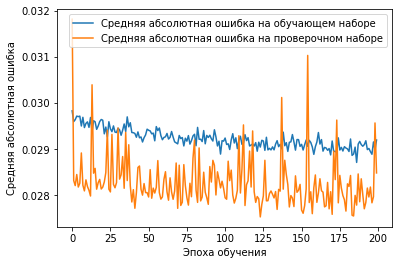

CPU times: total: 8min 8s
Wall time: 7min 36s


In [119]:
%%time

epochs = 200
optimizer = 'Adam' #rmsprop, Adam, SGD

model6.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])

hist6 = model6.fit(S_train, Y_train,
                   epochs = epochs,
                   batch_size = 1,
                   verbose = 0,
                   validation_data = (S_test, Y_test))

test_mse, test_mae = model6.evaluate(S_test, Y_test, verbose = 0)
train_mse = hist6.history['loss']
train_mae = hist6.history['mae']

pred_test = model6.predict(S_test)
pred_train = model6.predict(S_train)

print('-----------------------------')
print(train_mse[epochs-1], train_mae[epochs-1])
print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
print('-----------------------------')
print(test_mse, test_mae)
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')

# Считаем графики ошибки
plt.plot(hist6.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist6.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

<font size = 2><div style="text-align: justify">**Библиотека mlxtend:**</div></font>

In [61]:
#np.random.seed(2121)

clf1_0 = CatBoostRegressor(verbose = 0)
clf1_1 = AdaBoostRegressor()
clf1_2 = XGBRegressor()
clf1_3 = LGBMRegressor()
clf1_4 = GradientBoostingRegressor()
clf1_5 = RandomForestRegressor()

clf2_0 = LinearRegression()
#clf2_0 = CatBoostRegressor(verbose = 0)

reg = StackingCVRegressor(regressors = (clf1_0, clf1_1, clf1_2, clf1_3, clf1_4, clf1_5),
                          meta_regressor = clf2_0)

reg.fit(X_train, Y_train)

pred_train = reg.predict(X_train)
mse_train = mse(Y_train, pred_train)

print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = reg.predict(X_test)
mse_test = mse(Y_test, pred_test)

print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

Train R2 0.981
MAE на обучении: 0.056
Test R2 0.926
MAE на тесте: 0.1082


C:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but AdaBoostRegressor was fitted without feature names
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
C:\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


<font size = 2><div style="text-align: justify">**Библиотека mlens:**</div></font>

In [66]:
clf1_0 = CatBoostRegressor(verbose = 0)
clf1_1 = AdaBoostRegressor()
clf1_2 = XGBRegressor()
clf1_3 = LGBMRegressor()
clf1_4 = GradientBoostingRegressor()
clf1_5 = RandomForestRegressor()

level_0 = [clf1_0, clf1_1, clf1_2, clf1_3, clf1_4, clf1_5]

clf2_0 = LinearRegression()
#clf2_0 = CatBoostRegressor(verbose = 0)

reg = SuperLearner(folds = 3, scorer = mae, random_state = 2121, verbose = 2)
reg.add(level_0)
reg.add_meta(clf2_0)
reg.fit(X_train, Y_train)

pred_train = reg.predict(X_train)
mse_train = mse(Y_train, pred_train)

print("------------------")
print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = reg.predict(X_test)
mse_test = mse(Y_test, pred_test)

print("------------------")
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))


Fitting 2 layers
Processing layer-1             done | 00:00:06
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:06

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00
------------------
Train R2 0.983
MAE на обучении: 0.0527

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00
------------------
Test R2 0.927
MAE на тесте: 0.1073


<font size = 2><div style="text-align: justify">**Библиотека sklearn:**</div></font>

In [120]:
df_v1 = df.copy()
len(df_v1)

2399

In [121]:
#X = df_v1[['Общая площадь', 'Площадь кухни', 'Жилая площадь', 'Этаж 1', 'Этажей в доме', 
#           'Хронологический возраст', 'Долгота', 'Широта', 'pca(координата)', 'Тип санузла 2', 
#           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
#           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
#           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]
X = df_v1[['LN(Общая площадь)', 'Площадь кухни', 'Жилая площадь', 'Этажей в доме', 
           'Хронологический возраст', 'Долгота', 'Широта', 'Тип санузла 2', 
           '1к', '2к', '3к', '4к и более', 'студия', 'первый', 'последний', 'средний', 
           'деревянный', 'кирпичный', 'монолитный', 'панельный', 
           'дизайнерский', 'евро', 'косметический', 'требует ремонта']]

#Y = df_v1['Цена']
Y = df_v1['LN(Цена)']

# Делим имеющуюся выборку на обучающую и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [122]:
estimators = [('Cat', CatBoostRegressor(verbose = 0)),
              ('Ada', AdaBoostRegressor()), 
              ('XGB', XGBRegressor()),
              ('LGBM', LGBMRegressor()),
              ('GB', GradientBoostingRegressor()),
              ('RFR', RandomForestRegressor())]


reg = StackingRegressor(estimators = estimators,
                        final_estimator = LinearRegression())

reg.fit(X_train, Y_train).score(X_test, Y_test)

pred_train = reg.predict(X_train)
mse_train = mse(Y_train, pred_train)

print("------------------")
print(f'Train R2 {r2_score(Y_train, pred_train):.3f}')
#print(f'MSE на обучении {mse_train:.2f}')
print("MAE на обучении:", round(mae(Y_train, pred_train), 4))

pred_test = reg.predict(X_test)
mse_test = mse(Y_test, pred_test)

print("------------------")
print(f'Test R2 {r2_score(Y_test, pred_test):.3f}')
#print(f'MSE на тесте {mse_test:.2f}')
print("MAE на тесте:", round(mae(Y_test, pred_test), 4))

------------------
Train R2 0.984
MAE на обучении: 0.0512
------------------
Test R2 0.926
MAE на тесте: 0.1078


In [ ]:
from mlxtend.regressor import StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
lasso = Lasso(random_state=1)
svr_rbf = SVR(kernel='rbf')
regressors = [svr_lin, lr, ridge, lasso]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=svr_rbf)

params = {'lasso__alpha': [0.1, 1.0, 10.0],
          'ridge__alpha': [0.1, 1.0, 10.0],
          'svr__C': [0.1, 1.0, 10.0],
          'meta_regressor__C': [0.1, 1.0, 10.0, 100.0],
          'meta_regressor__gamma': [0.1, 1.0, 10.0]}

grid = GridSearchCV(estimator=stregr, 
                    param_grid=params, 
                    cv=5,
                    refit=True)
grid.fit(X, y)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))